In [1]:
gene_familly = None

In [2]:
# Parameters
gene_familly = "YABBY"


<div style="hwidth: 100%; background-color: #ddd; overflow:hidden; ">
    <div style="display: flex; justify-content: center; align-items: center; border-bottom: 10px solid #80c4e7; padding: 3px;">
        <h2 style="position: relative; top: 3px; left: 8px;">S2 Project: DNA Classification - (part2: Approach 2)</h2>
        <!--<img style="position: absolute; height: 68px; top: -2px;; right: 18px" src="./Content/Notebook-images/dna1.png"/>-->
    </div>
    <div style="padding: 3px 8px;">
        
1. <strong>Description</strong>:
   - In this approach, we represent DNA sequences using k-mer frequencies. Each sequence is encoded as a vector where each element represents the frequency of a specific k-mer in the sequence. This vector representation is then used as input to a neural network architecture for classification.

2. <strong>Pros</strong>:
   - Utilizes frequency analysis: By representing sequences based on the frequency of k-mers, the model can capture important patterns and motifs in the DNA sequences.
   - Flexible architecture: Neural networks provide a flexible framework for learning complex relationships between features, allowing the model to adapt to different types of data.

3. <strong>Cons</strong>:
   - Curse of dimensionality: Depending on the value of k and the size of the alphabet (e.g., DNA bases A, C, G, T), the feature space can become very large, leading to increased computational complexity and potential overfitting.
   - Loss of sequence information: By focusing solely on k-mer frequencies, the model may overlook important sequential dependencies and structural information present in the DNA sequences.
    </div>    
</div>

### 1 - Importing utils
The following code cells will import necessary libraries.

In [3]:
import os, random, string, itertools, warnings, sys, json
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from IPython.display import display, HTML
from sklearn.metrics import (
    confusion_matrix, 
    classification_report, 
    accuracy_score, 
    f1_score, 
    recall_score, 
    precision_score
)

from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import pad_sequences
from sklearn.feature_extraction import DictVectorizer
from keras.models import Sequential
from keras.layers import Dense, Input
from keras.layers import LSTM, SimpleRNN
from keras.layers import Flatten, Embedding, BatchNormalization, Dropout, MaxPooling1D, GlobalAveragePooling1D
from keras.preprocessing import sequence
from keras.layers import Conv1D

# OS
current_directory = os.getcwd()
root_directory = os.path.abspath(os.path.join(current_directory, os.pardir))
utils_directory = os.path.join(root_directory, 'processing')
sys.path.append(utils_directory)

# Import Utils
import fasta
from representation import DNA
from visualization import VISU, VISUReport

In [4]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  0


### 2 - Importing Dataset
The following function will read our preprocessed **.csv file** and return a pandas dataframe

In [5]:
# READ GENE_INFO JSON FILE

gene_info_path = "../data/gene_info.json"
dataset_path   = "../data/one_vs_other/"
with open(gene_info_path, 'r') as json_file:
    gene_info = json.load(json_file)

In [6]:
# FOCUS ON GENE FAMALLY

gene_dict = gene_info[gene_familly]
df_path = dataset_path+gene_dict['file_code']+".csv"

In [7]:
USE_FULL_DF = True

if USE_FULL_DF:
    dataset = pd.read_csv(df_path)
else:
    dataset_ = pd.read_csv(df_path)
    r = min(5000/len(dataset_), 1)
    _, dataset = train_test_split(dataset_, test_size=r, stratify=dataset_['class'], random_state=42)
dataset.head()

,id,sequence,length,class
0,Achn002711,MEIRRSKEVSVPCTSLFKTVTVRCGHCTNLLPVNMRGLLLPSTNQL...,213,1
1,Achn019201,MRCHVPVDELPMTCHKMVDMRTGQGTCSDGTKHFLVMDCGTTLCLG...,312,1
2,Achn032281,MRFMIHLQSKQEVSPELEADAEKGLDKRSPSLVISSDDEDDDEVPV...,104,1
3,Achn088151,MRGLLPPSANQLHLGHAFFSPQNLLEDIQNSSPNLLINHPNPNGLV...,309,1
4,Achn155211,MDLVPPPEQLCYVRCNFCNTVLAGFVNEIKKGQSSSSSSSTSSEPV...,73,1


In [8]:
report = VISUReport(gene_familly, dataset)

* **Model Utils**

In [9]:
domaine = "ACDEFGHIKLMNPQRSTVWYX"
def model_checkpoint(model_name):
    gene_familly_ = gene_familly.replace('/', '__')
    return tf.keras.callbacks.ModelCheckpoint(
        filepath="Output/Model/"+gene_familly_+"/"+model_name+".keras", 
        monitor='val_loss', 
        verbose=0, 
        save_best_only=True, 
        save_weights_only=False
    )
def early_stopping(patience=10):
    return tf.keras.callbacks.EarlyStopping(
        monitor="val_accuracy",
        patience=patience,
        verbose=0,
    )

### 4 - Training and Testing

<h4 style="background-color: #80c4e6; display: flex;">
    <ul><li>k=2</li></ul>
</h4>

In [10]:
k = 2
X, y, features_k2 = DNA.build_kmer_representation_v2(dataset, domaine=domaine, k=k, dtypes=['float16', 'int8'], asCudaDF=False)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_test.head()

,AA,AC,AD,AE,AF,AG,AH,AI,AK,AL,...,YN,YP,YQ,YR,YS,YT,YV,YW,YX,YY
591,0.009524,0.000000,0.000000,0.000000,0.004762,0.004762,0.004762,0.000000,0.009524,0.000000,...,0.004762,0.000000,0.000000,0.000000,0.000000,0.000000,0.004762,0.0,0.0,0.000000
1717,0.076023,0.000000,0.000000,0.000000,0.011696,0.011696,0.005848,0.000000,0.005848,0.000000,...,0.000000,0.005848,0.005848,0.000000,0.000000,0.005848,0.000000,0.0,0.0,0.000000
2228,0.001420,0.004261,0.004261,0.011364,0.002841,0.001420,0.001420,0.004261,0.004261,0.004261,...,0.000000,0.001420,0.000000,0.002841,0.000000,0.002841,0.002841,0.0,0.0,0.000000
3094,0.000000,0.000000,0.000000,0.000000,0.003155,0.000000,0.000000,0.000000,0.003155,0.000000,...,0.000000,0.003155,0.003155,0.006309,0.000000,0.003155,0.000000,0.0,0.0,0.006309
2575,0.009479,0.000000,0.000000,0.004739,0.000000,0.000000,0.000000,0.004739,0.014218,0.000000,...,0.004739,0.000000,0.000000,0.000000,0.004739,0.000000,0.000000,0.0,0.0,0.000000


In [11]:
print("X_train:", X_train.shape)
print("X_test:", X_test.shape)
print("y_train:", y_train.shape)
print("y_test:", y_test.shape)

NUM_CLASS  = 1
SEQ_LENGTH = X_train.shape[1]

X_train: (2726, 441)
X_test: (682, 441)
y_train: (2726,)
y_test: (682,)


* <span style="color: blue; font-weight: bold;">MODEL 1 : FEED-FORWARD NETWORKS</span>

In [12]:
name="FEEDFORWARD_k2"
def feedforward_net1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH):
    model = Sequential(name=name)
    model.add(Input(shape=(SEQ_LENGTH,)))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(num_output, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

# Build & train the model
model = feedforward_net1()
stop_callback = early_stopping(patience=10)
save_callback = model_checkpoint(name)

X_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)
history = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])

# Evaluate and score
test_scores = model.evaluate(X_test, y_test, verbose=0)
train_score = history.history.get('accuracy')[-1]
print("\n[Train Accuracy: {:.2f}% - Test Accuracy: {:.2f}%]".format(train_score*100, test_scores[1]*100))

Model: "FEEDFORWARD_k2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 256)                 │         113,152 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 156,417 (611.00 KB)

 Trainable params: 156,417 (611.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100


 1/35 ━━━━━━━━━━━━━━━━━━━━ 15s 466ms/step - accuracy: 0.5781 - loss: 0.6928

35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5854 - loss: 0.6642 - val_accuracy: 0.9762 - val_loss: 0.3975


Epoch 2/100


 1/35 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9531 - loss: 0.3971

35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9705 - loss: 0.3180 - val_accuracy: 0.9853 - val_loss: 0.0647


Epoch 3/100


 1/35 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9844 - loss: 0.0723

35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9832 - loss: 0.0634

35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9833 - loss: 0.0632 - val_accuracy: 0.9853 - val_loss: 0.0519


Epoch 4/100


 1/35 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 0.0137

32/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9972 - loss: 0.0197

35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9965 - loss: 0.0212 - val_accuracy: 0.9853 - val_loss: 0.0412


Epoch 5/100


 1/35 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 0.0179

32/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9937 - loss: 0.0261

35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9936 - loss: 0.0261 - val_accuracy: 0.9890 - val_loss: 0.0376


Epoch 6/100


 1/35 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9844 - loss: 0.0216

32/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9948 - loss: 0.0188

35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9949 - loss: 0.0189 - val_accuracy: 0.9799 - val_loss: 0.0837


Epoch 7/100


 1/35 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 0.0012

33/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9955 - loss: 0.0210

35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9954 - loss: 0.0209 - val_accuracy: 0.9835 - val_loss: 0.0574


Epoch 8/100


 1/35 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 0.0017

33/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9971 - loss: 0.0113

35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9970 - loss: 0.0116 - val_accuracy: 0.9853 - val_loss: 0.0432


Epoch 9/100


 1/35 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 0.0021

33/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9976 - loss: 0.0077

35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9975 - loss: 0.0081 - val_accuracy: 0.9890 - val_loss: 0.0391


Epoch 10/100


 1/35 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 0.0029

32/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9968 - loss: 0.0073

35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9969 - loss: 0.0071 - val_accuracy: 0.9853 - val_loss: 0.0802


Epoch 11/100


 1/35 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 9.5458e-04

34/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9987 - loss: 0.0043    

35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9985 - loss: 0.0046 - val_accuracy: 0.9853 - val_loss: 0.0473


Epoch 12/100


 1/35 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 0.0021

33/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9969 - loss: 0.0090

35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9968 - loss: 0.0094 - val_accuracy: 0.9872 - val_loss: 0.0430


Epoch 13/100


 1/35 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 0.0131

33/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9993 - loss: 0.0051

35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9993 - loss: 0.0049 - val_accuracy: 0.9853 - val_loss: 0.0502


Epoch 14/100


 1/35 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 0.0011

33/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 0.0018

35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 0.0018 - val_accuracy: 0.9853 - val_loss: 0.0581


Epoch 15/100


 1/35 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 2.5014e-04

32/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 0.0014    

35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 0.0014 - val_accuracy: 0.9872 - val_loss: 0.0769



[Train Accuracy: 100.00% - Test Accuracy: 98.97%]


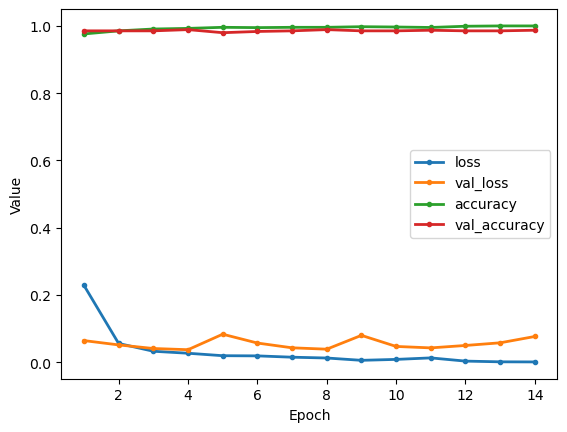

In [13]:
VISU.plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])

In [14]:
VISU.test_report(X_test, y_test, model=model,  args=[model.name, test_scores[1]*100, gene_familly, features_k2, len(dataset)]) 
report.add_report(X_test, y_test, model=model, history=history, args=[model.name, "---"])

 1/22 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 1/22 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 450us/step


<h4 style="background-color: #80c4e6; display: flex;">
    <ul><li>k=3</li></ul>
</h4>

In [15]:
k = 3
X, y, features_k3 = DNA.build_kmer_representation_v2(dataset, domaine=domaine, k=k, dtypes=['float16', 'int8'], asCudaDF=False)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_test.head()

,AAA,AAC,AAD,AAE,AAF,AAG,AAH,AAI,AAK,AAL,...,YYN,YYP,YYQ,YYR,YYS,YYT,YYV,YYW,YYX,YYY
591,0.004785,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.004785,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
1717,0.047059,0.0,0.0,0.000000,0.0,0.005882,0.0,0.0,0.005882,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
2228,0.000000,0.0,0.0,0.001422,0.0,0.000000,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
3094,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.003165,0.0,0.0,0.0,0.0,0.0,0.0
2575,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0


In [16]:
print("X_train:", X_train.shape)
print("X_test:", X_test.shape)
print("y_train:", y_train.shape)
print("y_test:", y_test.shape)

NUM_CLASS  = 1
SEQ_LENGTH = X_train.shape[1]

X_train: (2726, 8567)
X_test: (682, 8567)
y_train: (2726,)
y_test: (682,)


* <span style="color: blue; font-weight: bold;">MODEL 1 : FEED-FORWARD NETWORKS</span>

In [17]:
name="FEEDFORWARD_k3"
def feedforward_net1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH):
    model = Sequential(name=name)
    model.add(Input(shape=(SEQ_LENGTH,)))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(num_output, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

# Build & train the model
model = feedforward_net1()
stop_callback = early_stopping(patience=10)
save_callback = model_checkpoint(name)

X_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)
history = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])

# Evaluate and score
test_scores = model.evaluate(X_test, y_test, verbose=0)
train_score = history.history.get('accuracy')[-1]
print("\n[Train Accuracy: {:.2f}% - Test Accuracy: {:.2f}%]".format(train_score*100, test_scores[1]*100))

Model: "FEEDFORWARD_k3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_5 (Dense)                      │ (None, 256)                 │       2,193,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,236,673 (8.53 MB)

 Trainable params: 2,236,673 (8.53 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100


 1/35 ━━━━━━━━━━━━━━━━━━━━ 16s 476ms/step - accuracy: 0.4375 - loss: 0.6932

10/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6326 - loss: 0.6916   

19/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7258 - loss: 0.6872

28/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7773 - loss: 0.6789

35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8071 - loss: 0.6665 - val_accuracy: 0.9853 - val_loss: 0.3261


Epoch 2/100


 1/35 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 1.0000 - loss: 0.3102

10/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9912 - loss: 0.2762 

20/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9901 - loss: 0.2300

29/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9902 - loss: 0.1989

35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9902 - loss: 0.1812 - val_accuracy: 0.9927 - val_loss: 0.0217


Epoch 3/100


 1/35 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9844 - loss: 0.0467

10/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9919 - loss: 0.0233 

20/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9936 - loss: 0.0187

30/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9944 - loss: 0.0172

35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9947 - loss: 0.0167 - val_accuracy: 0.9927 - val_loss: 0.0173


Epoch 4/100


 1/35 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 1.0000 - loss: 0.0034

10/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 0.0028 

19/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9996 - loss: 0.0030

28/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9994 - loss: 0.0032

35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9993 - loss: 0.0032 - val_accuracy: 0.9927 - val_loss: 0.0181


Epoch 5/100


 1/35 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 1.0000 - loss: 0.0038

10/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 0.0020 

19/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 0.0017

28/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 0.0016

35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 0.0016 - val_accuracy: 0.9927 - val_loss: 0.0214


Epoch 6/100


 1/35 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 1.0000 - loss: 5.7503e-04

10/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 6.3781e-04 

19/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 6.1832e-04

28/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 6.0686e-04

35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 6.0081e-04 - val_accuracy: 0.9927 - val_loss: 0.0280


Epoch 7/100


 1/35 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 1.0000 - loss: 1.1778e-04

10/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 2.2118e-04 

20/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 2.4713e-04

29/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 2.4995e-04

35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 2.4821e-04 - val_accuracy: 0.9927 - val_loss: 0.0316


Epoch 8/100


 1/35 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 1.0000 - loss: 1.1899e-04

11/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 2.1409e-04 

21/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 3.5420e-04

31/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 3.6987e-04

35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 3.8542e-04 - val_accuracy: 0.9927 - val_loss: 0.0274


Epoch 9/100


 1/35 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 1.0000 - loss: 2.8815e-04

11/35 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 2.4009e-04 

21/35 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 2.1393e-04

31/35 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 2.1038e-04

35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 2.0764e-04 - val_accuracy: 0.9927 - val_loss: 0.0331


Epoch 10/100


 1/35 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 1.0000 - loss: 8.5537e-05

11/35 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 9.1059e-05 

20/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 9.2738e-05

29/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 8.7120e-05

35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 8.3509e-05 - val_accuracy: 0.9927 - val_loss: 0.0371


Epoch 11/100


 1/35 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 1.0000 - loss: 6.2161e-05

10/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 4.3686e-05 

20/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 3.9067e-05

29/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 3.7141e-05

35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 3.7826e-05 - val_accuracy: 0.9927 - val_loss: 0.0374


Epoch 12/100


 1/35 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 1.0000 - loss: 1.9499e-05

10/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 2.6752e-05 

20/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 2.9698e-05

30/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 3.1587e-05

35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 3.2486e-05 - val_accuracy: 0.9927 - val_loss: 0.0363



[Train Accuracy: 100.00% - Test Accuracy: 99.41%]


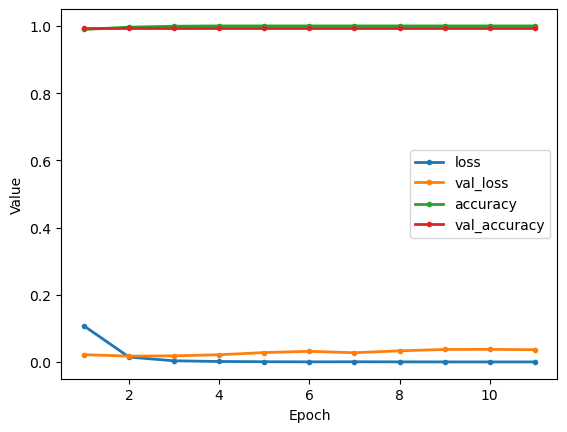

In [18]:
VISU.plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])

In [19]:
VISU.test_report(X_test, y_test, model=model,  args=[model.name, test_scores[1]*100, gene_familly, features_k3, len(dataset)]) 
report.add_report(X_test, y_test, model=model, history=history, args=[model.name, "---"])

 1/22 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 1/22 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 894us/step


<h4 style="background-color: #80c4e6; display: flex;">
    <ul><li>k=4</li></ul>
</h4>

In [20]:
k = 4
X, y, features_k4 = DNA.build_kmer_representation_v2(dataset, domaine=domaine, k=k, dtypes=['float16', 'int8'], asCudaDF=False)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_test.head()

,AAAA,AAAC,AAAD,AAAE,AAAF,AAAG,AAAH,AAAI,AAAK,AAAL,...,YYYM,YYYN,YYYP,YYYQ,YYYR,YYYS,YYYT,YYYV,YYYX,YYYY
591,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.004808,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1717,0.035503,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.005917,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2228,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3094,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2575,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [21]:
NUM_CLASS  = 1
SEQ_LENGTH = X_train.shape[1]

* <span style="color: blue; font-weight: bold;">MODEL 2 : FEED-FORWARD NETWORKS</span>

In [22]:
name="FEEDFORWARD_k4"
def feedforward_net1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH):
    model = Sequential(name=name)
    model.add(Input(shape=(SEQ_LENGTH,)))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(num_output, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

# Build & train the model
model = feedforward_net1()
stop_callback = early_stopping(patience=10)
save_callback = model_checkpoint(name)

X_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)
history = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])


# Evaluate and score
test_scores = model.evaluate(X_test, y_test, verbose=0)
train_score = history.history.get('accuracy')[-1]
print("\n[Train Accuracy: {:.2f}% - Test Accuracy: {:.2f}%]".format(train_score*100, test_scores[1]*100))

Model: "FEEDFORWARD_k4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_10 (Dense)                     │ (None, 256)                 │      32,634,880 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 32,676,097 (124.65 MB)

 Trainable params: 32,676,097 (124.65 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100


 1/35 ━━━━━━━━━━━━━━━━━━━━ 21s 638ms/step - accuracy: 0.4375 - loss: 0.6932

 2/35 ━━━━━━━━━━━━━━━━━━━━ 2s 68ms/step - accuracy: 0.4492 - loss: 0.6931  

 3/35 ━━━━━━━━━━━━━━━━━━━━ 2s 69ms/step - accuracy: 0.4557 - loss: 0.6931

 4/35 ━━━━━━━━━━━━━━━━━━━━ 2s 68ms/step - accuracy: 0.4688 - loss: 0.6930

 5/35 ━━━━━━━━━━━━━━━━━━━━ 2s 68ms/step - accuracy: 0.4837 - loss: 0.6928

 6/35 ━━━━━━━━━━━━━━━━━━━━ 2s 69ms/step - accuracy: 0.5016 - loss: 0.6927

 7/35 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - accuracy: 0.5218 - loss: 0.6925

 8/35 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - accuracy: 0.5411 - loss: 0.6923

 9/35 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - accuracy: 0.5595 - loss: 0.6921

10/35 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - accuracy: 0.5770 - loss: 0.6918

11/35 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - accuracy: 0.5933 - loss: 0.6915

12/35 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - accuracy: 0.6086 - loss: 0.6911

13/35 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - accuracy: 0.6226 - loss: 0.6908

14/35 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - accuracy: 0.6355 - loss: 0.6903

15/35 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - accuracy: 0.6476 - loss: 0.6899

16/35 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - accuracy: 0.6588 - loss: 0.6894

17/35 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - accuracy: 0.6693 - loss: 0.6888

18/35 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - accuracy: 0.6791 - loss: 0.6882

19/35 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - accuracy: 0.6883 - loss: 0.6876

20/35 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - accuracy: 0.6970 - loss: 0.6869

21/35 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - accuracy: 0.7050 - loss: 0.6861

22/35 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.7125 - loss: 0.6853

23/35 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.7195 - loss: 0.6845

24/35 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.7262 - loss: 0.6836

25/35 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.7325 - loss: 0.6826

26/35 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.7385 - loss: 0.6815

27/35 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.7442 - loss: 0.6804

28/35 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.7495 - loss: 0.6792

29/35 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.7546 - loss: 0.6780

30/35 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.7595 - loss: 0.6767

31/35 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.7641 - loss: 0.6753

32/35 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.7685 - loss: 0.6738

33/35 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.7727 - loss: 0.6722

34/35 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.7768 - loss: 0.6706

35/35 ━━━━━━━━━━━━━━━━━━━━ 4s 113ms/step - accuracy: 0.7842 - loss: 0.6675 - val_accuracy: 0.9872 - val_loss: 0.3622


Epoch 2/100


 1/35 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - accuracy: 1.0000 - loss: 0.3489

 2/35 ━━━━━━━━━━━━━━━━━━━━ 2s 70ms/step - accuracy: 1.0000 - loss: 0.3420

 3/35 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step - accuracy: 1.0000 - loss: 0.3381

 4/35 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step - accuracy: 1.0000 - loss: 0.3356

 5/35 ━━━━━━━━━━━━━━━━━━━━ 2s 68ms/step - accuracy: 1.0000 - loss: 0.3323

 6/35 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - accuracy: 0.9996 - loss: 0.3280

 7/35 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - accuracy: 0.9993 - loss: 0.3233

 8/35 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - accuracy: 0.9984 - loss: 0.3189

 9/35 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - accuracy: 0.9976 - loss: 0.3143

10/35 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - accuracy: 0.9966 - loss: 0.3097

11/35 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - accuracy: 0.9958 - loss: 0.3048

12/35 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - accuracy: 0.9951 - loss: 0.2998

13/35 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - accuracy: 0.9947 - loss: 0.2948

14/35 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - accuracy: 0.9943 - loss: 0.2898

15/35 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - accuracy: 0.9941 - loss: 0.2849

16/35 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - accuracy: 0.9939 - loss: 0.2801

17/35 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - accuracy: 0.9937 - loss: 0.2754

18/35 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - accuracy: 0.9935 - loss: 0.2708

19/35 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - accuracy: 0.9934 - loss: 0.2664

20/35 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - accuracy: 0.9932 - loss: 0.2620

21/35 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.9930 - loss: 0.2579

22/35 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.9928 - loss: 0.2538

23/35 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.9926 - loss: 0.2499

24/35 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.9925 - loss: 0.2461

25/35 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.9924 - loss: 0.2423

26/35 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.9923 - loss: 0.2388

27/35 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.9922 - loss: 0.2353

28/35 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.9921 - loss: 0.2319

29/35 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.9920 - loss: 0.2287

30/35 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.9919 - loss: 0.2255

31/35 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.9919 - loss: 0.2224

32/35 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.9918 - loss: 0.2194

33/35 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.9918 - loss: 0.2165

34/35 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.9918 - loss: 0.2136

35/35 ━━━━━━━━━━━━━━━━━━━━ 4s 102ms/step - accuracy: 0.9917 - loss: 0.2084 - val_accuracy: 0.9890 - val_loss: 0.0280


Epoch 3/100


 1/35 ━━━━━━━━━━━━━━━━━━━━ 3s 93ms/step - accuracy: 1.0000 - loss: 0.0068

 2/35 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step - accuracy: 1.0000 - loss: 0.0089

 3/35 ━━━━━━━━━━━━━━━━━━━━ 2s 68ms/step - accuracy: 0.9983 - loss: 0.0112

 4/35 ━━━━━━━━━━━━━━━━━━━━ 2s 68ms/step - accuracy: 0.9977 - loss: 0.0123

 5/35 ━━━━━━━━━━━━━━━━━━━━ 2s 68ms/step - accuracy: 0.9976 - loss: 0.0125

 6/35 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - accuracy: 0.9975 - loss: 0.0124

 7/35 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - accuracy: 0.9972 - loss: 0.0129

 8/35 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - accuracy: 0.9971 - loss: 0.0131

 9/35 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - accuracy: 0.9970 - loss: 0.0132

10/35 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - accuracy: 0.9970 - loss: 0.0131

11/35 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - accuracy: 0.9970 - loss: 0.0130

12/35 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - accuracy: 0.9970 - loss: 0.0130

13/35 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - accuracy: 0.9969 - loss: 0.0129

14/35 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - accuracy: 0.9969 - loss: 0.0128

15/35 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - accuracy: 0.9969 - loss: 0.0127

16/35 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - accuracy: 0.9969 - loss: 0.0126

17/35 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - accuracy: 0.9969 - loss: 0.0124

18/35 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - accuracy: 0.9969 - loss: 0.0123

19/35 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - accuracy: 0.9970 - loss: 0.0122

20/35 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - accuracy: 0.9970 - loss: 0.0121

21/35 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.9970 - loss: 0.0119

22/35 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.9971 - loss: 0.0118

23/35 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.9971 - loss: 0.0117

24/35 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.9972 - loss: 0.0116

25/35 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.9972 - loss: 0.0115

26/35 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.9972 - loss: 0.0113

27/35 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.9973 - loss: 0.0112

28/35 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.9973 - loss: 0.0111

29/35 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.9974 - loss: 0.0110

30/35 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.9974 - loss: 0.0110

31/35 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.9974 - loss: 0.0109

32/35 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.9975 - loss: 0.0108

33/35 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.9975 - loss: 0.0107

34/35 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.9975 - loss: 0.0106

35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 83ms/step - accuracy: 0.9976 - loss: 0.0105 - val_accuracy: 0.9945 - val_loss: 0.0170


Epoch 4/100


 1/35 ━━━━━━━━━━━━━━━━━━━━ 3s 97ms/step - accuracy: 1.0000 - loss: 0.0026

 2/35 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step - accuracy: 1.0000 - loss: 0.0028

 3/35 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step - accuracy: 1.0000 - loss: 0.0028

 4/35 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step - accuracy: 1.0000 - loss: 0.0027

 5/35 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step - accuracy: 1.0000 - loss: 0.0027

 6/35 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - accuracy: 1.0000 - loss: 0.0027

 7/35 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - accuracy: 1.0000 - loss: 0.0027

 8/35 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - accuracy: 1.0000 - loss: 0.0027

 9/35 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - accuracy: 1.0000 - loss: 0.0027

10/35 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - accuracy: 1.0000 - loss: 0.0027

11/35 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - accuracy: 1.0000 - loss: 0.0026

12/35 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - accuracy: 1.0000 - loss: 0.0026

13/35 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - accuracy: 1.0000 - loss: 0.0026

14/35 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - accuracy: 1.0000 - loss: 0.0026

15/35 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - accuracy: 1.0000 - loss: 0.0025

16/35 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - accuracy: 1.0000 - loss: 0.0025

17/35 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - accuracy: 1.0000 - loss: 0.0025

18/35 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - accuracy: 1.0000 - loss: 0.0025

19/35 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - accuracy: 1.0000 - loss: 0.0024

20/35 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - accuracy: 1.0000 - loss: 0.0024

21/35 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 1.0000 - loss: 0.0024

22/35 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 1.0000 - loss: 0.0024

23/35 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 1.0000 - loss: 0.0023

24/35 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 1.0000 - loss: 0.0023

25/35 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 1.0000 - loss: 0.0023

26/35 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 1.0000 - loss: 0.0023

27/35 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 1.0000 - loss: 0.0023

28/35 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 1.0000 - loss: 0.0023

29/35 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 1.0000 - loss: 0.0023

30/35 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 1.0000 - loss: 0.0022

31/35 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 1.0000 - loss: 0.0022

32/35 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 1.0000 - loss: 0.0022

33/35 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 1.0000 - loss: 0.0022

34/35 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 1.0000 - loss: 0.0022

35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 72ms/step - accuracy: 1.0000 - loss: 0.0022 - val_accuracy: 0.9908 - val_loss: 0.0209


Epoch 5/100


 1/35 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - accuracy: 1.0000 - loss: 0.0011

 2/35 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step - accuracy: 1.0000 - loss: 9.7861e-04

 3/35 ━━━━━━━━━━━━━━━━━━━━ 2s 68ms/step - accuracy: 1.0000 - loss: 0.0010    

 4/35 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step - accuracy: 1.0000 - loss: 0.0010

 5/35 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step - accuracy: 1.0000 - loss: 0.0010

 6/35 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - accuracy: 1.0000 - loss: 0.0010

 7/35 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - accuracy: 1.0000 - loss: 0.0010

 8/35 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - accuracy: 1.0000 - loss: 0.0010

 9/35 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - accuracy: 1.0000 - loss: 0.0010

10/35 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - accuracy: 1.0000 - loss: 0.0010

11/35 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - accuracy: 1.0000 - loss: 0.0011

12/35 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - accuracy: 1.0000 - loss: 0.0011

13/35 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - accuracy: 1.0000 - loss: 0.0011

14/35 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - accuracy: 1.0000 - loss: 0.0011

15/35 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - accuracy: 1.0000 - loss: 0.0011

16/35 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - accuracy: 1.0000 - loss: 0.0011

17/35 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - accuracy: 1.0000 - loss: 0.0011

18/35 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - accuracy: 1.0000 - loss: 0.0010

19/35 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - accuracy: 1.0000 - loss: 0.0010

20/35 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - accuracy: 1.0000 - loss: 0.0010

21/35 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 1.0000 - loss: 0.0010

22/35 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 1.0000 - loss: 0.0010

23/35 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 1.0000 - loss: 0.0010

24/35 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 1.0000 - loss: 0.0010

25/35 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 1.0000 - loss: 0.0010

26/35 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 1.0000 - loss: 0.0010

27/35 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 1.0000 - loss: 0.0010

28/35 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 1.0000 - loss: 0.0010

29/35 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 1.0000 - loss: 0.0010

30/35 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 1.0000 - loss: 0.0010

31/35 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 1.0000 - loss: 0.0010

32/35 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 1.0000 - loss: 0.0010

33/35 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 1.0000 - loss: 0.0010

34/35 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 1.0000 - loss: 9.9836e-04

35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 72ms/step - accuracy: 1.0000 - loss: 9.9104e-04 - val_accuracy: 0.9908 - val_loss: 0.0266


Epoch 6/100


 1/35 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - accuracy: 1.0000 - loss: 5.2429e-04

 2/35 ━━━━━━━━━━━━━━━━━━━━ 2s 72ms/step - accuracy: 1.0000 - loss: 7.1163e-04

 3/35 ━━━━━━━━━━━━━━━━━━━━ 2s 70ms/step - accuracy: 1.0000 - loss: 7.2002e-04

 4/35 ━━━━━━━━━━━━━━━━━━━━ 2s 69ms/step - accuracy: 1.0000 - loss: 7.1051e-04

 5/35 ━━━━━━━━━━━━━━━━━━━━ 2s 68ms/step - accuracy: 1.0000 - loss: 6.8641e-04

 6/35 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - accuracy: 1.0000 - loss: 6.6353e-04

 7/35 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - accuracy: 1.0000 - loss: 6.7982e-04

 8/35 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - accuracy: 1.0000 - loss: 6.9402e-04

 9/35 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - accuracy: 1.0000 - loss: 7.1002e-04

10/35 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - accuracy: 1.0000 - loss: 7.2591e-04

11/35 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - accuracy: 1.0000 - loss: 7.3590e-04

12/35 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - accuracy: 1.0000 - loss: 7.4156e-04

13/35 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - accuracy: 1.0000 - loss: 7.4458e-04

14/35 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - accuracy: 1.0000 - loss: 7.4644e-04

15/35 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - accuracy: 1.0000 - loss: 7.4706e-04

16/35 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - accuracy: 1.0000 - loss: 7.4605e-04

17/35 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - accuracy: 1.0000 - loss: 7.4389e-04

18/35 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - accuracy: 1.0000 - loss: 7.4104e-04

19/35 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - accuracy: 1.0000 - loss: 7.3762e-04

20/35 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - accuracy: 1.0000 - loss: 7.3632e-04

21/35 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 1.0000 - loss: 7.3549e-04

22/35 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 1.0000 - loss: 7.3451e-04

23/35 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 1.0000 - loss: 7.3439e-04

24/35 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 1.0000 - loss: 7.3650e-04

25/35 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 1.0000 - loss: 7.3766e-04

26/35 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 1.0000 - loss: 7.3857e-04

27/35 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 1.0000 - loss: 7.3906e-04

28/35 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 1.0000 - loss: 7.3890e-04

29/35 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 1.0000 - loss: 7.3835e-04

30/35 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 1.0000 - loss: 7.3748e-04

31/35 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 1.0000 - loss: 7.3650e-04

32/35 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 1.0000 - loss: 7.3531e-04

33/35 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 1.0000 - loss: 7.3393e-04

34/35 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 1.0000 - loss: 7.3249e-04

35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 74ms/step - accuracy: 1.0000 - loss: 7.2991e-04 - val_accuracy: 0.9908 - val_loss: 0.0234


Epoch 7/100


 1/35 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - accuracy: 1.0000 - loss: 3.8072e-04

 2/35 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - accuracy: 1.0000 - loss: 3.8306e-04

 3/35 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step - accuracy: 1.0000 - loss: 3.6598e-04

 4/35 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step - accuracy: 1.0000 - loss: 3.5333e-04

 5/35 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step - accuracy: 1.0000 - loss: 3.7139e-04

 6/35 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - accuracy: 1.0000 - loss: 3.7963e-04

 7/35 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - accuracy: 1.0000 - loss: 3.8287e-04

 8/35 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - accuracy: 1.0000 - loss: 3.8712e-04

 9/35 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - accuracy: 1.0000 - loss: 3.8932e-04

10/35 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - accuracy: 1.0000 - loss: 3.8950e-04

11/35 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - accuracy: 1.0000 - loss: 3.9408e-04

12/35 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - accuracy: 1.0000 - loss: 3.9768e-04

13/35 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - accuracy: 1.0000 - loss: 3.9939e-04

14/35 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - accuracy: 1.0000 - loss: 4.0040e-04

15/35 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - accuracy: 1.0000 - loss: 4.0121e-04

16/35 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - accuracy: 1.0000 - loss: 4.0127e-04

17/35 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - accuracy: 1.0000 - loss: 4.0109e-04

18/35 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - accuracy: 1.0000 - loss: 4.0066e-04

19/35 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - accuracy: 1.0000 - loss: 4.0056e-04

20/35 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - accuracy: 1.0000 - loss: 4.0013e-04

21/35 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 1.0000 - loss: 3.9993e-04

22/35 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 1.0000 - loss: 4.0010e-04

23/35 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 1.0000 - loss: 3.9999e-04

24/35 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 1.0000 - loss: 3.9970e-04

25/35 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 1.0000 - loss: 4.0044e-04

26/35 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 1.0000 - loss: 4.0102e-04

27/35 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 1.0000 - loss: 4.0139e-04

28/35 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 1.0000 - loss: 4.0157e-04

29/35 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 1.0000 - loss: 4.0177e-04

30/35 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 1.0000 - loss: 4.0181e-04

31/35 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 1.0000 - loss: 4.0161e-04

32/35 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 1.0000 - loss: 4.0131e-04

33/35 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 1.0000 - loss: 4.0090e-04

34/35 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 1.0000 - loss: 4.0041e-04

35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 73ms/step - accuracy: 1.0000 - loss: 3.9949e-04 - val_accuracy: 0.9908 - val_loss: 0.0296


Epoch 8/100


 1/35 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - accuracy: 1.0000 - loss: 2.9201e-04

 2/35 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step - accuracy: 1.0000 - loss: 2.7336e-04

 3/35 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step - accuracy: 1.0000 - loss: 2.7169e-04

 4/35 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step - accuracy: 1.0000 - loss: 2.7647e-04

 5/35 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - accuracy: 1.0000 - loss: 2.7695e-04

 6/35 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - accuracy: 1.0000 - loss: 2.7732e-04

 7/35 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - accuracy: 1.0000 - loss: 2.7842e-04

 8/35 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - accuracy: 1.0000 - loss: 2.7720e-04

 9/35 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - accuracy: 1.0000 - loss: 2.7604e-04

10/35 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - accuracy: 1.0000 - loss: 2.7389e-04

11/35 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - accuracy: 1.0000 - loss: 2.7252e-04

12/35 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - accuracy: 1.0000 - loss: 2.7114e-04

13/35 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - accuracy: 1.0000 - loss: 2.6966e-04

14/35 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - accuracy: 1.0000 - loss: 2.6800e-04

15/35 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - accuracy: 1.0000 - loss: 2.6659e-04

16/35 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - accuracy: 1.0000 - loss: 2.6498e-04

17/35 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - accuracy: 1.0000 - loss: 2.6342e-04

18/35 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - accuracy: 1.0000 - loss: 2.6232e-04

19/35 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - accuracy: 1.0000 - loss: 2.6123e-04

20/35 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - accuracy: 1.0000 - loss: 2.6032e-04

21/35 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 1.0000 - loss: 2.5941e-04

22/35 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 1.0000 - loss: 2.5834e-04

23/35 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 1.0000 - loss: 2.5721e-04

24/35 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 1.0000 - loss: 2.5598e-04

25/35 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 1.0000 - loss: 2.5479e-04

26/35 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 1.0000 - loss: 2.5354e-04

27/35 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 1.0000 - loss: 2.5226e-04

28/35 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 1.0000 - loss: 2.5134e-04

29/35 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 1.0000 - loss: 2.5040e-04

30/35 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 1.0000 - loss: 2.4956e-04

31/35 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 1.0000 - loss: 2.4902e-04

32/35 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 1.0000 - loss: 2.4881e-04

33/35 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 1.0000 - loss: 2.4859e-04

34/35 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 1.0000 - loss: 2.4855e-04

35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 73ms/step - accuracy: 1.0000 - loss: 2.4848e-04 - val_accuracy: 0.9908 - val_loss: 0.0325


Epoch 9/100


 1/35 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - accuracy: 1.0000 - loss: 1.4136e-04

 2/35 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - accuracy: 1.0000 - loss: 1.4028e-04

 3/35 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step - accuracy: 1.0000 - loss: 1.3731e-04

 4/35 ━━━━━━━━━━━━━━━━━━━━ 3s 103ms/step - accuracy: 1.0000 - loss: 1.3818e-04

 5/35 ━━━━━━━━━━━━━━━━━━━━ 2s 99ms/step - accuracy: 1.0000 - loss: 1.4149e-04 

 6/35 ━━━━━━━━━━━━━━━━━━━━ 2s 93ms/step - accuracy: 1.0000 - loss: 1.4849e-04

 7/35 ━━━━━━━━━━━━━━━━━━━━ 2s 89ms/step - accuracy: 1.0000 - loss: 1.5822e-04

 8/35 ━━━━━━━━━━━━━━━━━━━━ 2s 86ms/step - accuracy: 1.0000 - loss: 1.6452e-04

 9/35 ━━━━━━━━━━━━━━━━━━━━ 2s 84ms/step - accuracy: 1.0000 - loss: 1.6912e-04

10/35 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - accuracy: 1.0000 - loss: 1.7229e-04

11/35 ━━━━━━━━━━━━━━━━━━━━ 1s 82ms/step - accuracy: 1.0000 - loss: 1.7491e-04

12/35 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step - accuracy: 1.0000 - loss: 1.7703e-04

13/35 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step - accuracy: 1.0000 - loss: 1.7863e-04

14/35 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - accuracy: 1.0000 - loss: 1.8026e-04

15/35 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - accuracy: 1.0000 - loss: 1.8385e-04

16/35 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - accuracy: 1.0000 - loss: 1.8684e-04

17/35 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - accuracy: 1.0000 - loss: 1.8926e-04

18/35 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - accuracy: 1.0000 - loss: 1.9112e-04

19/35 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - accuracy: 1.0000 - loss: 1.9248e-04

20/35 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - accuracy: 1.0000 - loss: 1.9481e-04

21/35 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - accuracy: 1.0000 - loss: 1.9701e-04

22/35 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 1.0000 - loss: 1.9933e-04

23/35 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 1.0000 - loss: 2.0153e-04

24/35 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 1.0000 - loss: 2.0356e-04

25/35 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 1.0000 - loss: 2.0530e-04

26/35 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 1.0000 - loss: 2.0669e-04

27/35 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 1.0000 - loss: 2.0791e-04

28/35 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 1.0000 - loss: 2.0891e-04

29/35 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 1.0000 - loss: 2.0971e-04

30/35 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 1.0000 - loss: 2.1044e-04

31/35 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 1.0000 - loss: 2.1113e-04

32/35 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 1.0000 - loss: 2.1190e-04

33/35 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 1.0000 - loss: 2.1258e-04

34/35 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 1.0000 - loss: 2.1307e-04

35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 78ms/step - accuracy: 1.0000 - loss: 2.1396e-04 - val_accuracy: 0.9908 - val_loss: 0.0294


Epoch 10/100


 1/35 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - accuracy: 1.0000 - loss: 1.3452e-04

 2/35 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step - accuracy: 1.0000 - loss: 1.9460e-04

 3/35 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step - accuracy: 1.0000 - loss: 2.0499e-04

 4/35 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step - accuracy: 1.0000 - loss: 2.0418e-04

 5/35 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step - accuracy: 1.0000 - loss: 1.9934e-04

 6/35 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - accuracy: 1.0000 - loss: 1.9571e-04

 7/35 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - accuracy: 1.0000 - loss: 1.9661e-04

 8/35 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - accuracy: 1.0000 - loss: 1.9805e-04

 9/35 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - accuracy: 1.0000 - loss: 2.0084e-04

10/35 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - accuracy: 1.0000 - loss: 2.0155e-04

11/35 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - accuracy: 1.0000 - loss: 2.0210e-04

12/35 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - accuracy: 1.0000 - loss: 2.0230e-04

13/35 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - accuracy: 1.0000 - loss: 2.0240e-04

14/35 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - accuracy: 1.0000 - loss: 2.0216e-04

15/35 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - accuracy: 1.0000 - loss: 2.0181e-04

16/35 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - accuracy: 1.0000 - loss: 2.0245e-04

17/35 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - accuracy: 1.0000 - loss: 2.0272e-04

18/35 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - accuracy: 1.0000 - loss: 2.0276e-04

19/35 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - accuracy: 1.0000 - loss: 2.0254e-04

20/35 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - accuracy: 1.0000 - loss: 2.0210e-04

21/35 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 1.0000 - loss: 2.0167e-04

22/35 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 1.0000 - loss: 2.0120e-04

23/35 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 1.0000 - loss: 2.0056e-04

24/35 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 1.0000 - loss: 1.9978e-04

25/35 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 1.0000 - loss: 1.9888e-04

26/35 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 1.0000 - loss: 1.9802e-04

27/35 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 1.0000 - loss: 1.9716e-04

28/35 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 1.0000 - loss: 1.9686e-04

29/35 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 1.0000 - loss: 1.9687e-04

30/35 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 1.0000 - loss: 1.9673e-04

31/35 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 1.0000 - loss: 1.9653e-04

32/35 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 1.0000 - loss: 1.9629e-04

33/35 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 1.0000 - loss: 1.9596e-04

34/35 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 1.0000 - loss: 1.9557e-04

35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 73ms/step - accuracy: 1.0000 - loss: 1.9486e-04 - val_accuracy: 0.9908 - val_loss: 0.0315


Epoch 11/100


 1/35 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - accuracy: 1.0000 - loss: 1.3517e-04

 2/35 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step - accuracy: 1.0000 - loss: 1.2074e-04

 3/35 ━━━━━━━━━━━━━━━━━━━━ 2s 68ms/step - accuracy: 1.0000 - loss: 1.2033e-04

 4/35 ━━━━━━━━━━━━━━━━━━━━ 2s 68ms/step - accuracy: 1.0000 - loss: 1.1569e-04

 5/35 ━━━━━━━━━━━━━━━━━━━━ 2s 68ms/step - accuracy: 1.0000 - loss: 1.1681e-04

 6/35 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - accuracy: 1.0000 - loss: 1.1708e-04

 7/35 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - accuracy: 1.0000 - loss: 1.9299e-04

 8/35 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - accuracy: 1.0000 - loss: 2.4167e-04

 9/35 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - accuracy: 1.0000 - loss: 2.7863e-04

10/35 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - accuracy: 1.0000 - loss: 3.0358e-04

11/35 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - accuracy: 1.0000 - loss: 3.2094e-04

12/35 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - accuracy: 1.0000 - loss: 3.3335e-04

13/35 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - accuracy: 1.0000 - loss: 3.4188e-04

14/35 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - accuracy: 1.0000 - loss: 3.4793e-04

15/35 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - accuracy: 1.0000 - loss: 3.5219e-04

16/35 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - accuracy: 1.0000 - loss: 3.5454e-04

17/35 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - accuracy: 1.0000 - loss: 3.5581e-04

18/35 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - accuracy: 1.0000 - loss: 3.5605e-04

19/35 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - accuracy: 1.0000 - loss: 3.5581e-04

20/35 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - accuracy: 1.0000 - loss: 3.5514e-04

21/35 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 1.0000 - loss: 3.5406e-04

22/35 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 1.0000 - loss: 3.5264e-04

23/35 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 1.0000 - loss: 3.5109e-04

24/35 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 1.0000 - loss: 3.4951e-04

25/35 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 1.0000 - loss: 3.4802e-04

26/35 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 1.0000 - loss: 3.4640e-04

27/35 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 1.0000 - loss: 3.4498e-04

28/35 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 1.0000 - loss: 3.4343e-04

29/35 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 1.0000 - loss: 3.4190e-04

30/35 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 1.0000 - loss: 3.4022e-04

31/35 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 1.0000 - loss: 3.3850e-04

32/35 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 1.0000 - loss: 3.3679e-04

33/35 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 1.0000 - loss: 3.3503e-04

34/35 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 1.0000 - loss: 3.3327e-04

35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 73ms/step - accuracy: 1.0000 - loss: 3.3002e-04 - val_accuracy: 0.9908 - val_loss: 0.0238


Epoch 12/100


 1/35 ━━━━━━━━━━━━━━━━━━━━ 2s 83ms/step - accuracy: 1.0000 - loss: 7.4430e-05

 2/35 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step - accuracy: 1.0000 - loss: 8.6598e-05

 3/35 ━━━━━━━━━━━━━━━━━━━━ 2s 68ms/step - accuracy: 1.0000 - loss: 8.7736e-05

 4/35 ━━━━━━━━━━━━━━━━━━━━ 2s 68ms/step - accuracy: 1.0000 - loss: 9.6557e-05

 5/35 ━━━━━━━━━━━━━━━━━━━━ 2s 68ms/step - accuracy: 1.0000 - loss: 1.0361e-04

 6/35 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - accuracy: 1.0000 - loss: 1.1004e-04

 7/35 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - accuracy: 1.0000 - loss: 1.1439e-04

 8/35 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - accuracy: 1.0000 - loss: 1.1734e-04

 9/35 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - accuracy: 1.0000 - loss: 1.1939e-04

10/35 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - accuracy: 1.0000 - loss: 1.2084e-04

11/35 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - accuracy: 1.0000 - loss: 1.2193e-04

12/35 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - accuracy: 1.0000 - loss: 1.2292e-04

13/35 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - accuracy: 1.0000 - loss: 1.2356e-04

14/35 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - accuracy: 1.0000 - loss: 1.2447e-04

15/35 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - accuracy: 1.0000 - loss: 1.2543e-04

16/35 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - accuracy: 1.0000 - loss: 1.2647e-04

17/35 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - accuracy: 1.0000 - loss: 1.2760e-04

18/35 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - accuracy: 1.0000 - loss: 1.2849e-04

19/35 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - accuracy: 1.0000 - loss: 1.2910e-04

20/35 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - accuracy: 1.0000 - loss: 1.2950e-04

21/35 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 1.0000 - loss: 1.3005e-04

22/35 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 1.0000 - loss: 1.3059e-04

23/35 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 1.0000 - loss: 1.3101e-04

24/35 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 1.0000 - loss: 1.3131e-04

25/35 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 1.0000 - loss: 1.3161e-04

26/35 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 1.0000 - loss: 1.3185e-04

27/35 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 1.0000 - loss: 1.3200e-04

28/35 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 1.0000 - loss: 1.3207e-04

29/35 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 1.0000 - loss: 1.3210e-04

30/35 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 1.0000 - loss: 1.3208e-04

31/35 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 1.0000 - loss: 1.3203e-04

32/35 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 1.0000 - loss: 1.3215e-04

33/35 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 1.0000 - loss: 1.3221e-04

34/35 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 1.0000 - loss: 1.3220e-04

35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 73ms/step - accuracy: 1.0000 - loss: 1.3218e-04 - val_accuracy: 0.9908 - val_loss: 0.0302


Epoch 13/100


 1/35 ━━━━━━━━━━━━━━━━━━━━ 2s 85ms/step - accuracy: 1.0000 - loss: 6.6420e-05

 2/35 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step - accuracy: 1.0000 - loss: 7.6117e-05

 3/35 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step - accuracy: 1.0000 - loss: 7.8536e-05

 4/35 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step - accuracy: 1.0000 - loss: 8.0512e-05

 5/35 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - accuracy: 1.0000 - loss: 8.1149e-05

 6/35 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - accuracy: 1.0000 - loss: 8.0797e-05

 7/35 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - accuracy: 1.0000 - loss: 8.0476e-05

 8/35 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - accuracy: 1.0000 - loss: 8.0048e-05

 9/35 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - accuracy: 1.0000 - loss: 7.9880e-05

10/35 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - accuracy: 1.0000 - loss: 8.0552e-05

11/35 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - accuracy: 1.0000 - loss: 8.1707e-05

12/35 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - accuracy: 1.0000 - loss: 8.3297e-05

13/35 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - accuracy: 1.0000 - loss: 8.4910e-05

14/35 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - accuracy: 1.0000 - loss: 8.6058e-05

15/35 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - accuracy: 1.0000 - loss: 8.6943e-05

16/35 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - accuracy: 1.0000 - loss: 8.7571e-05

17/35 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - accuracy: 1.0000 - loss: 8.8236e-05

18/35 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - accuracy: 1.0000 - loss: 8.8790e-05

19/35 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - accuracy: 1.0000 - loss: 8.9265e-05

20/35 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - accuracy: 1.0000 - loss: 8.9707e-05

21/35 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 1.0000 - loss: 9.0007e-05

22/35 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 1.0000 - loss: 9.0232e-05

23/35 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 1.0000 - loss: 9.0319e-05

24/35 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 1.0000 - loss: 9.0349e-05

25/35 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 1.0000 - loss: 9.2066e-05

26/35 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 1.0000 - loss: 9.3513e-05

27/35 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 1.0000 - loss: 9.4800e-05

28/35 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 1.0000 - loss: 9.5972e-05

29/35 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 1.0000 - loss: 9.7090e-05

30/35 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 1.0000 - loss: 9.8073e-05

31/35 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 1.0000 - loss: 9.9034e-05

32/35 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 1.0000 - loss: 9.9864e-05

33/35 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 1.0000 - loss: 1.0057e-04

34/35 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 1.0000 - loss: 1.0125e-04

35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 73ms/step - accuracy: 1.0000 - loss: 1.0249e-04 - val_accuracy: 0.9908 - val_loss: 0.0300



[Train Accuracy: 100.00% - Test Accuracy: 99.41%]


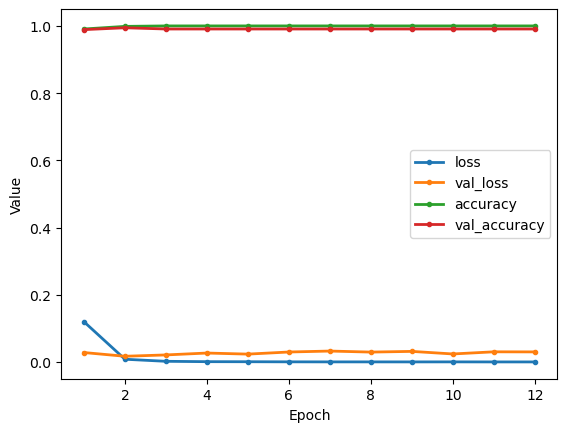

In [23]:
VISU.plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])

In [24]:
VISU.test_report(X_test, y_test, model=model,  args=[model.name, test_scores[1]*100, gene_familly, features_k4, len(dataset)]) 
report.add_report(X_test, y_test, model=model, history=history, args=[model.name, "---"])

 1/22 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step

 8/22 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 

15/22 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


 1/22 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step

 8/22 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 

15/22 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


In [25]:
report.save()

Report saved as Output/Reports/YABBY/report_6VVXCQ3X.html


<h4 style="background-color: #80c4e6; display: flex;">
    <ul><li>k=5</li></ul>
</h4>

In [26]:
"""k = 5
X, y, features_k5 = DNA.build_kmer_representation_v2(dataset, domaine=domaine, k=k, dtypes=['float16', 'int8'], asCudaDF=False)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_test.head()"""

"k = 5\nX, y, features_k5 = DNA.build_kmer_representation_v2(dataset, domaine=domaine, k=k, dtypes=['float16', 'int8'], asCudaDF=False)\nX_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)\nX_test.head()"

In [27]:
"""NUM_CLASS  = 1
SEQ_LENGTH = X_train.shape[1]"""

'NUM_CLASS  = 1\nSEQ_LENGTH = X_train.shape[1]'

* <span style="color: blue; font-weight: bold;">MODEL 3 : FEED-FORWARD NETWORKS</span>

In [28]:
"""name="FEEDFORWARD_k5"
def feedforward_net1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH):
    model = Sequential(name=name)
    model.add(Input(shape=(SEQ_LENGTH,)))
    model.add(Dense(2*256, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(num_output, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

# Build & train the model
model = feedforward_net1()
stop_callback = early_stopping(patience=10)
save_callback = model_checkpoint(name)

X_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)
history = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])

# Evaluate and score
test_scores = model.evaluate(X_test, y_test, verbose=0)
train_score = history.history.get('accuracy')[-1]
print("\n[Train Accuracy: {:.2f}% - Test Accuracy: {:.2f}%]".format(train_score*100, test_scores[1]*100))"""

'name="FEEDFORWARD_k5"\ndef feedforward_net1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH):\n    model = Sequential(name=name)\n    model.add(Input(shape=(SEQ_LENGTH,)))\n    model.add(Dense(2*256, activation=\'relu\'))\n    model.add(Dropout(rate=0.2))\n    model.add(Dense(128, activation=\'relu\'))\n    model.add(Dropout(rate=0.2))\n    model.add(Dense(64, activation=\'relu\'))\n    model.add(Dropout(rate=0.2))\n    model.add(Dense(num_output, activation=\'sigmoid\'))\n    model.compile(loss=\'binary_crossentropy\', optimizer=\'adam\', metrics=[\'accuracy\'])\n    model.summary()\n    return model\n\n# Build & train the model\nmodel = feedforward_net1()\nstop_callback = early_stopping(patience=10)\nsave_callback = model_checkpoint(name)\n\nX_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)\nhistory = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])\n\n# Evaluate and sc

In [29]:
"""VISU.plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])"""

"VISU.plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])"

In [30]:
"""VISU.test_report(X_test, y_test, model=model,  args=[model.name, test_scores[1]*100, gene_familly, features_k5, len(dataset)]) 
report.add_report(X_test, y_test, model=model, history=history, args=[model.name, "---"])
report.save('end')"""

'VISU.test_report(X_test, y_test, model=model,  args=[model.name, test_scores[1]*100, gene_familly, features_k5, len(dataset)]) \nreport.add_report(X_test, y_test, model=model, history=history, args=[model.name, "---"])\nreport.save(\'end\')'

In [31]:
# END

In [32]:
######################################### DEBUG TO OPTIMIZE K-MER LOEADER FUNCTION ###########################################